In [1]:
from dataloader import TraceDataset
import torch
from models import trace, mnist
from torchviz import make_dot
import torch.nn.functional as F
from tqdm.notebook import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
num_words = 215
trace_dataset = TraceDataset(num_words)
# Train/test split 80/20
train_size = int(0.8 * len(trace_dataset))
test_size = len(trace_dataset) - train_size
batch_size = 32
train_dataset, test_dataset = torch.utils.data.random_split(trace_dataset, [train_size, test_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # features: (batch_size, max_word_len, 7)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
device = "cuda"
epochs = 30

model = trace(num_words, trace_dataset.max_word_length, batch_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Computational graph plots

In [9]:
model

PCModel(
  (layers): Sequential(
    (input): InputLayer(shape=(20, 7))
    (phoneme_layer): MiddleLayer(in_shape=7, out_shape=128)
    (word_layer): MiddleLayer(in_shape=128, out_shape=200)
    (output): OutputLayer(in_shape=200, out_shape=200)
  )
)

In [10]:
batch = next(iter(dataloader))
words, features, labels_ind = batch.values()
labels = F.one_hot(labels_ind, num_classes=num_words).float().to(device)
features = features.to(device)

model.reset()

model.clamp(input_data=features[:, 0, :])
rec, loss_bw, layer_losses = model.backward()
out = model.forward(features[:, 0, :])
loss_fw = F.cross_entropy(out, labels)
loss = loss_fw + loss_bw
loss.backward()

In [11]:
dot = make_dot(loss, params=dict(list(model.named_parameters()) + [('features', features), ('labels', labels)]))
dot.format = 'png'
dot.render('trace_single_step')

'trace_single_step.png'

## Training on TRACE

In [ ]:
def evaluate(model, dataloader, steps_per_ph, desc="Evaluating"):
    model.eval()
    accuracies = []
    preds = []
    original_words = []
    with torch.no_grad():
        for batch in dataloader:
            words, features, labels_ind = batch.values()
            labels = F.one_hot(labels_ind, num_classes=num_words).float().to(device)
            features = features.to(device)

            model.reset()

            for i in range(trace_dataset.max_word_length):
                model.clamp(input_data=features[:, i, :])
                for j in range(steps_per_ph):
                    rec, loss_bw, layer_losses = model.backward()
                    out = model.forward(features[:, i, :])
            preds.append(model.layers.output.state.argmax(dim=1))
            correct = preds[-1].eq(labels_ind.to(device)).sum().item()

            accuracy = 100.0 * correct / len(labels_ind)
            accuracies.append(accuracy)
            original_words.extend(words)
    return sum(accuracies) / len(accuracies), torch.cat(preds, dim=0), original_words


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

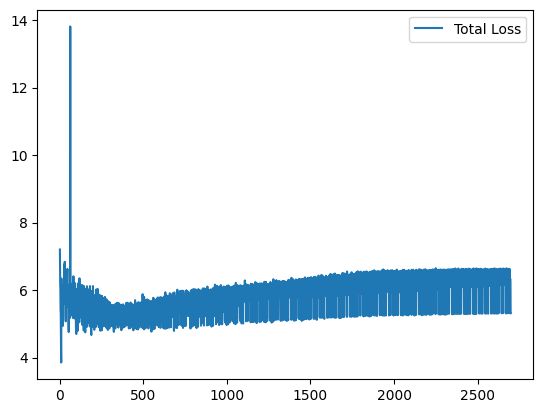

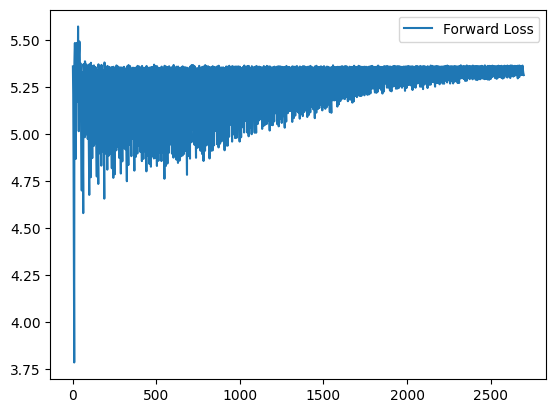

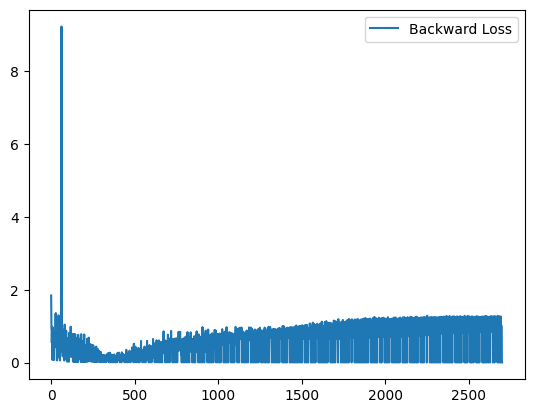

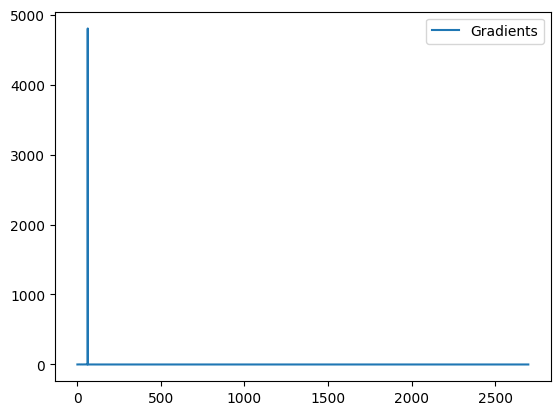

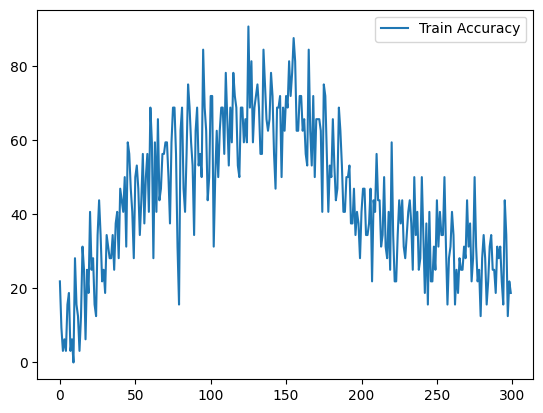

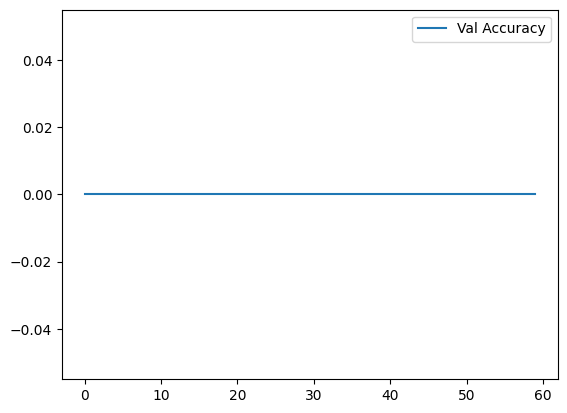

In [ ]:
step = 0.05
steps_per_phoneme = 5
losses_bw = []
losses_fw = []
losses = []
gradients = []
accuracies = []
val_accuracies = [0]
pbar = tqdm(total=epochs * len(train_dataloader), desc="Training")
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        words, features, labels_ind = batch.values()
        labels = F.one_hot(labels_ind, num_classes=num_words).float().to(device)
        features = features.to(device)

        model.reset()

        for i in range(trace_dataset.max_word_length):
            for j in range(steps_per_phoneme):
                model.clamp(input_data=features[:, i, :])
                optimizer.zero_grad()
                rec, loss_bw, layer_losses = model.backward()
                out = model.forward(features[:, i, :])
                loss_fw = F.cross_entropy(out, labels)
                loss = loss_fw + loss_bw
                loss.backward()
                optimizer.step()
                model.detach_states()
            losses.append(loss.item())
            losses_bw.append(loss_bw.item())
            losses_fw.append(loss_fw.item())
            weights = [torch.linalg.norm(p.data).item() for p in model.parameters()]
            grads_fw = [
                torch.linalg.norm(p.grad).item()
                for p in model.parameters()
                if p.grad is not None
            ]
            gradients.append(sum(grads_fw) / len(grads_fw))

        correct = model.layers.output.state.argmax(dim=1).eq(labels_ind.to(device)).sum().item()
        accuracy = 100.0 * correct / len(labels_ind)
        accuracies.append(accuracy)
        pbar.set_description(
            f"Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f} Acc: {accuracy:.2f}, Val {val_accuracies[-1]:.2f}%"
        )
        pbar.update(1)

    val_acc, _, _ = evaluate(model, test_dataloader, steps_per_phoneme, desc="Validation")
    val_accuracies.append(val_acc)

pbar.close()

sns.lineplot(data=losses, label='Total Loss')
plt.show()
sns.lineplot(data=losses_fw, label='Forward Loss')
plt.show()
sns.lineplot(data=losses_bw, label='Backward Loss')
plt.show()
sns.lineplot(data=gradients, label='Gradients')
plt.show()
sns.lineplot(data=accuracies, label='Train Accuracy')
sns.lineplot(data=val_accuracies, label='Val Accuracy')
plt.show()


In [11]:
acc, predictions, original_words = evaluate(model, test_dataloader, steps_per_phoneme)


In [15]:
for p, w in zip(predictions, original_words):
    pred_w = trace_dataset.words_padded[p.item()]
    if pred_w[:len(w)] != w:
        print(f"Predicted: {pred_w}, Original: {w}")

Predicted: Sip------, Original: lip
Predicted: prab^bli-, Original: prab^b^l
Predicted: pat------, Original: part
Predicted: S^t------, Original: Sut
Predicted: k^p------, Original: kap
Predicted: ad-------, Original: rad
Predicted: Si-------, Original: si
Predicted: st^did---, Original: -


In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    zeros = torch.zeros_like(data)
    optimizer.zero_grad()

    model.reset()

    model.release_clamp()
    model.clamp(zeros, None)
    for _ in range(n_zero_steps):
        model.backward()
        model(zeros, step=step)
    loss_zero, _ = model.backward()

    model.release_clamp()
    model.clamp(data, None)
    for _ in range(n_steps):
        model.backward()
        model(data, step=step)
    loss_bw, losses = model.backward()
    output = model(data, step=step)
    loss_fw = F.cross_entropy(output, target)
    ratio = loss_fw / loss_bw
    loss = 10 * (0.1 * loss_zero + 0.1 * loss_bw + 0.8 * loss_fw)
    loss.backward()
    weights = [torch.linalg.norm(p.data).item() for p in model.parameters()]
    grads_fw = [
        torch.linalg.norm(p.grad).item()
        for p in model.parameters()
        if p.grad is not None
    ]
    optimizer.step()

    # Compute accuracy.
    pred = model.layers.output.state.argmax(
        dim=1, keepdim=True
    ).detach()  # get the index of the max log-probability
    correct = pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100.0 * correct / len(data)